# 残差网络（ResNet）

残差块

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

输入和输出形状一致

In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

增加输出通道数的同时，减半输出的高和宽

In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

ResNet模型

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

观察一下ResNet中不同模块的输入形状是如何变化的

In [5]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


训练模型

In [2]:
torch.set_float32_matmul_precision("medium")

In [3]:
import time

In [4]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

loss 0.018, train acc 0.995, test acc 0.916
2857.4 examples/sec on cuda:0
CPU times: user 3min 44s, sys: 8.76 s, total: 3min 53s
Wall time: 3min 54s


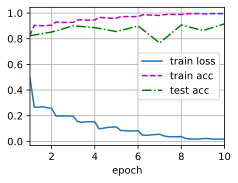

In [9]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 练习

2. 参考ResNet论文 (He et al., 2016)中的表1，以实现不同的变体。

In [10]:
class ResNet_34(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(*resnet_block(64, 64, 3, first_block=True))
        self.conv3 = nn.Sequential(*resnet_block(64, 128, 4))
        self.conv4 = nn.Sequential(*resnet_block(128, 256, 6))
        self.conv5 = nn.Sequential(*resnet_block(256, 512, 3))
        self.net = nn.Sequential(
            self.conv1, self.conv2, self.conv3, self.conv4, self.conv5,
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(512, 10)
        )
        
    def forward(self, x):
        return self.net(x)

loss 0.042, train acc 0.985, test acc 0.846
1737.4 examples/sec on cuda:0
CPU times: user 6min 3s, sys: 12.5 s, total: 6min 16s
Wall time: 6min 22s


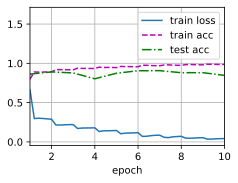

In [11]:
%%time
net = ResNet_34()
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

3. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。

In [5]:
class Bottleneck(nn.Module):  
    def __init__(self, input_channels, middle_channels, output_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, middle_channels,
                               kernel_size=1)
        self.conv2 = nn.Conv2d(middle_channels, middle_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv3 = nn.Conv2d(middle_channels, output_channels,
                               kernel_size=1)
        if use_1x1conv:
            self.conv4 = nn.Conv2d(input_channels, output_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv4 = nn.Conv2d(input_channels, output_channels,
                                   kernel_size=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.bn2 = nn.BatchNorm2d(middle_channels)
        self.bn3 = nn.BatchNorm2d(output_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        X = self.conv4(X)
        Y += X
        return F.relu(Y)

In [6]:
def bottleneck_block(input_channels, middle_channels, output_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Bottleneck(input_channels, middle_channels, output_channels,
                                  use_1x1conv=True, strides=2))
        elif i == 0:
            blk.append(Bottleneck(input_channels, middle_channels, output_channels))
        else:
            blk.append(Bottleneck(output_channels, middle_channels, output_channels))
    return blk

In [7]:
class ResNet_50(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(*bottleneck_block(64, 64, 256, 3, first_block=True))
        self.conv3 = nn.Sequential(*bottleneck_block(256, 128, 512, 4))
        self.conv4 = nn.Sequential(*bottleneck_block(512, 256, 1024, 6))
        self.conv5 = nn.Sequential(*bottleneck_block(1024, 512, 2048, 3))
        self.net = nn.Sequential(
            self.conv1, self.conv2, self.conv3, self.conv4, self.conv5,
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(2048, 10)
        )
        self.net.apply(d2l.init_cnn)
        
    def forward(self, x):
        return self.net(x)

net = ResNet_50()

loss 0.125, train acc 0.954, test acc 0.903
679.8 examples/sec on cuda:0
CPU times: user 15min 32s, sys: 14.4 s, total: 15min 46s
Wall time: 15min 48s


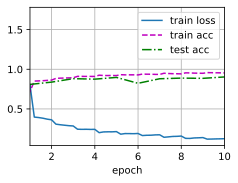

In [8]:
%%time
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

4. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见 (He et al., 2016)中的图1。

In [1]:
import time
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

torch.set_float32_matmul_precision("medium")

In [2]:
class Residual_proposed(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return Y

In [3]:
def resnet_block_proposed(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual_proposed(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual_proposed(num_channels, num_channels))
    return blk


In [9]:
class ResNet_18_proposed(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(1), nn.ReLU(),
            nn.Conv2d(1, 64, kernel_size=7, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(*resnet_block_proposed(64, 64, 2, first_block=True))
        self.conv3 = nn.Sequential(*resnet_block_proposed(64, 128, 2))
        self.conv4 = nn.Sequential(*resnet_block_proposed(128, 256, 2))
        self.conv5 = nn.Sequential(*resnet_block_proposed(256, 512, 2))
        self.net = nn.Sequential(
            self.conv1, self.conv2, self.conv3, self.conv4, self.conv5,
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(512, 10)
        )
        
    def forward(self, x):
        return self.net(x)
 
net = ResNet_18_proposed()

In [10]:
num_epochs, batch_size = 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

loss 0.393, train acc 0.864, test acc 0.840
3037.8 examples/sec on cuda:0
CPU times: user 3min 31s, sys: 9.48 s, total: 3min 41s
Wall time: 3min 42s


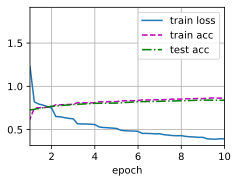

In [11]:
%%time
lr = 0.001
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.124, train acc 0.959, test acc 0.891
3063.6 examples/sec on cuda:0
CPU times: user 3min 30s, sys: 9.38 s, total: 3min 40s
Wall time: 3min 41s


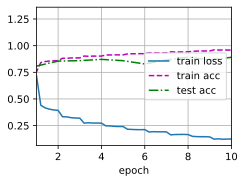

In [12]:
%%time
net = ResNet_18_proposed()
lr = 0.01
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [16]:
class ResNet_34_proposed(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(1), nn.ReLU(),
            nn.Conv2d(1, 64, kernel_size=7, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(*resnet_block_proposed(64, 64, 3, first_block=True))
        self.conv3 = nn.Sequential(*resnet_block_proposed(64, 128, 4))
        self.conv4 = nn.Sequential(*resnet_block_proposed(128, 256, 6))
        self.conv5 = nn.Sequential(*resnet_block_proposed(256, 512, 3))
        self.net = nn.Sequential(
            self.conv1, self.conv2, self.conv3, self.conv4, self.conv5,
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(512, 10)
        )
        
    def forward(self, x):
        return self.net(x)

loss 0.071, train acc 0.980, test acc 0.895
1795.4 examples/sec on cuda:0
CPU times: user 5min 53s, sys: 12.2 s, total: 6min 5s
Wall time: 6min 6s


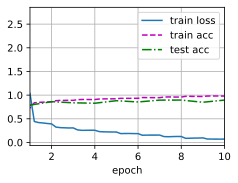

In [17]:
%%time
net = ResNet_34_proposed()
lr = 0.01
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [22]:
class Bottleneck_proposed(nn.Module):  
    def __init__(self, input_channels, middle_channels, output_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, middle_channels,
                               kernel_size=1)
        self.conv2 = nn.Conv2d(middle_channels, middle_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv3 = nn.Conv2d(middle_channels, output_channels,
                               kernel_size=1)
        if use_1x1conv:
            self.conv4 = nn.Conv2d(input_channels, output_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv4 = nn.Conv2d(input_channels, output_channels,
                                   kernel_size=1)
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.bn2 = nn.BatchNorm2d(middle_channels)
        self.bn3 = nn.BatchNorm2d(middle_channels)

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        Y = self.conv3(F.relu(self.bn3(Y)))
        X = self.conv4(X)
        Y += X
        return Y

In [23]:
def bottleneck_block_proposed(input_channels, middle_channels, output_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Bottleneck_proposed(input_channels, middle_channels, output_channels,
                                  use_1x1conv=True, strides=2))
        elif i == 0:
            blk.append(Bottleneck_proposed(input_channels, middle_channels, output_channels))
        else:
            blk.append(Bottleneck_proposed(output_channels, middle_channels, output_channels))
    return blk

In [24]:
class ResNet_50(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(1), nn.ReLU(),
            nn.Conv2d(1, 64, kernel_size=7, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.conv2 = nn.Sequential(*bottleneck_block_proposed(64, 64, 256, 3, first_block=True))
        self.conv3 = nn.Sequential(*bottleneck_block_proposed(256, 128, 512, 4))
        self.conv4 = nn.Sequential(*bottleneck_block_proposed(512, 256, 1024, 6))
        self.conv5 = nn.Sequential(*bottleneck_block_proposed(1024, 512, 2048, 3))
        self.net = nn.Sequential(
            self.conv1, self.conv2, self.conv3, self.conv4, self.conv5,
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(2048, 10)
        )
        self.net.apply(d2l.init_cnn)
        
    def forward(self, x):
        return self.net(x)

loss 0.150, train acc 0.950, test acc 0.870
680.0 examples/sec on cuda:0
CPU times: user 15min 33s, sys: 15.1 s, total: 15min 48s
Wall time: 15min 49s


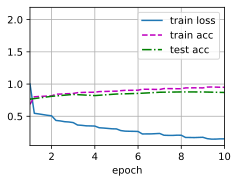

In [26]:
%%time
net = ResNet_50()
lr = 0.005
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())